<a href="https://colab.research.google.com/github/PavelKitaev/machine_learning/blob/main/lab1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**0. Постановка задачи**

Задача классификации - зависимость рейтинга фильма от продолжительности, возрастных ограничений, наличия в фильме насилия, ругательст, наготы, алкоголя, пугающих моментов.

**1. Чтение данных**

In [308]:
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [334]:
url = "https://raw.githubusercontent.com/PavelKitaev/machine_learning/main/imdb.csv"
data = pd.read_csv(url)
rows = data.shape[0]
columns = data.shape[1]

print("Строки - ", rows)
print("Столбцы - ", columns)
data.head(10)

Строки -  6178
Столбцы -  14


,Name,Date,Rate,Votes,Genre,Duration,Type,Certificate,Episodes,Nudity,Violence,Profanity,Alcohol,Frightening
0,No Time to Die,2021,7.6,"107,163","Action, Adventure, Thriller",163,Film,PG-13,-,Mild,Moderate,Mild,Mild,Moderate
1,The Guilty,2021,6.3,"64,375","Crime, Drama, Thriller",90,Film,R,-,None,None,Severe,None,Moderate
2,The Many Saints of Newark,2021,6.4,"27,145","Crime, Drama",120,Film,R,-,Moderate,Severe,Severe,Moderate,Moderate
3,Venom: Let There Be Carnage,2021,6.4,"30,443","Action, Adventure, Sci-Fi",97,Film,PG-13,-,None,Moderate,Moderate,Mild,Moderate
4,Dune,2021,8.3,"84,636","Action, Adventure, Drama",155,Film,PG-13,-,None,Moderate,None,Mild,Moderate
5,Ted Lasso,2021,8.8,"117,562","Comedy, Drama, Sport",30,Series,TV-MA,23,Mild,None,Severe,Mild,None
6,Free Guy,2021,7.3,"153,835","Action, Adventure, Comedy",115,Film,PG-13,-,Mild,Moderate,Moderate,None,Mild
7,House of the Dragon,2021,No Rate,No Votes,"Action, Adventure, Drama",None,Series,None,10,No Rate,No Rate,No Rate,No Rate,No Rate
8,What If...?,2021,7.6,"51,959","Animation, Action, Adventure",None,Series,TV-14,18,None,Moderate,Mild,Mild,Moderate
9,Sex Education,2021,8.3,"220,201","Comedy, Drama",45,Series,TV-MA,25,Severe,Mild,Severe,Moderate,Mild


**Подготовка данных**

Удаление строк с отсутствующими значениями, а также корректировка типов данных.

In [335]:
# Удаление строк, которые характеризуют сериалы
data = data.loc[data['Type'] != 'Series']

# Удаление столбца с жанрами и количеством эпизодов
data = data.drop("Episodes", axis=1)
data = data.drop("Genre", axis=1)

# Удаление строк с отсутствующими значениями
data = data.loc[data['Rate'] != 'No Rate']
data = data.loc[data['Votes'] != 'No Votes']
data = data.loc[data['Duration'] != 'None']

#data = data.loc[data['Nudity'] != 'No Rate']
#data = data.loc[data['Violence'] != 'No Rate']
#data = data.loc[data['Profanity'] != 'No Rate']
#data = data.loc[data['Alcohol'] != 'No Rate']
#data = data.loc[data['Frightening'] != 'No Rate']

data = data.loc[data['Certificate'] != 'Passed']
data = data.loc[data['Certificate'] != 'Not Rated']

# Удаление запятой из значений 'Votes' для корректного преобразования в int
data['Votes'] = data['Votes'].str.replace(',', '')

# Преобразование данных о наличии в фильме насилия, алкоголя, пугающих моментов, матов, наготы в числовые данные
# 0 - Отсутствует (None)
# 1 - Мало (Mild)
# 2 - Умерено (Moderate)
# 3 - Много (Severe)

data['Nudity'].replace(['No Rate', 'None', 'Mild', 'Moderate', 'Severe'], [1, 0, 1, 2, 3], inplace=True)
data['Violence'].replace(['No Rate', 'None', 'Mild', 'Moderate', 'Severe'], [1, 0, 1, 2, 3], inplace=True)
data['Profanity'].replace(['No Rate', 'None', 'Mild', 'Moderate', 'Severe'], [1, 0, 1, 2, 3], inplace=True)
data['Alcohol'].replace(['No Rate', 'None', 'Mild', 'Moderate', 'Severe'], [1, 0, 1, 2, 3], inplace=True)
data['Frightening'].replace(['No Rate', 'None', 'Mild', 'Moderate', 'Severe'], [1, 0, 1, 2, 3], inplace=True)

# Корректировка типов
data['Rate'] = data['Rate'].astype('float64')
data['Votes'] = data['Votes'].astype('int64')
data['Duration'] = data['Duration'].astype('int64')
data['Certificate'] = data['Certificate'].astype('category')
data['Nudity'] = data['Nudity'].astype('int64')
data['Violence'] = data['Violence'].astype('int64')
data['Profanity'] = data['Profanity'].astype('int64')
data['Alcohol'] = data['Alcohol'].astype('int64')
data['Frightening'] = data['Frightening'].astype('int64')

# Преобразование данных о возрастном рейтинге (С интерпритацией на систему рейтинга РФ)
data['Certificate'].replace(['None', 'GP', 'Unrated', 'E', 'TV-Y', 'TV-Y7', 'G', 'TV-G', 'PG', 'Approved', 'TV-PG', 'PG-13', 'M', 'M-PG', 'M/PG', 'TV-14', 'R', 'TV-MA', 'NC-17', '(Banned)', 'X'],
    [0, 0, 0, 0, 0, 7, 14, 14, 14, 14, 14, 12, 12, 12, 12, 14, 18, 18, 18, 18, 18], inplace=True)

# Переводим рейтинг из 10-ти бальной системы в условную 4-х бальную
# 0-3.9 - плохо (1)
# 4-5.9 - нормально (2)
# 6-7.9 - хорошо (3)
# 8-10 - отлично (4)

data['Rate'] = data['Rate'].mask(((data['Rate'] >= 0) & (data['Rate'] <= 3.9)), 1)
data['Rate'] = data['Rate'].mask(((data['Rate'] >= 4.0) & (data['Rate'] <= 5.9)), 2)
data['Rate'] = data['Rate'].mask(((data['Rate'] >= 6.0) & (data['Rate'] <= 7.9)), 3)
data['Rate'] = data['Rate'].mask(((data['Rate'] >= 8.0) & (data['Rate'] <= 10.0)), 4)
data['Rate'] = data['Rate'].astype('int64')

rows = data.shape[0]
columns = data.shape[1]

print("Строки - ", rows)
print("Столбцы - ", columns)

Строки -  4084
Столбцы -  12


До обработки данные содержали 6178 строк. После - 4084

Убедимся в отсутствии пропущенных значений:

In [336]:
|numerical_columns = ['Rate', 'Votes', 'Duration']
data[numerical_columns].count(axis = 0)

Rate        4084
Votes       4084
Duration    4084
dtype: int64

In [337]:
categorical_columns = ['Certificate', 'Nudity', 'Violence', 'Profanity', 'Alcohol', 'Frightening']
data[categorical_columns].count(axis = 0)

Certificate    4084
Nudity         4084
Violence       4084
Profanity      4084
Alcohol        4084
Frightening    4084
dtype: int64

**2. Визуализация данных**

In [313]:
# Количественные признаки
data.describe()

,Date,Rate,Votes,Duration,Nudity,Violence,Profanity,Alcohol,Frightening
count,3799.000000,3799.000000,3.799000e+03,3799.000000,3799.000000,3799.000000,3799.000000,3799.000000,3799.000000
mean,2004.900500,2.859700,1.698114e+05,111.340353,1.089234,1.715188,1.611213,1.103975,1.595946
std,14.299626,0.544062,2.180143e+05,20.014166,0.901808,0.944181,0.925156,0.699419,0.942359
min,1932.000000,1.000000,1.280000e+02,11.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1997.000000,3.000000,4.505100e+04,97.000000,0.000000,1.000000,1.000000,1.000000,1.000000
50%,2008.000000,3.000000,1.014460e+05,108.000000,1.000000,2.000000,2.000000,1.000000,2.000000
75%,2016.000000,3.000000,2.093455e+05,121.000000,2.000000,2.000000,2.000000,1.000000,2.000000
max,2021.000000,4.000000,2.474122e+06,242.000000,3.000000,3.000000,3.000000,3.000000,3.000000


Количественные признаки:
1. Date - Год выпуска. Первый фильм (сериал) в наборе данных выпущен в 2005 году, последний - в 2023
2. Rate - Рейтинг. Минимальный - 1, максимальный - 4
3. Votes - Количество оценок. Минимальное - 125 222, максимальное - 2 474 122
4. Duration - Продолжительность. Минимальная - 94.5, максимальное - 900 (в минутах)

Rate-Votes: 0.4541756912503866
Duration-Votes: 0.33920397464954116


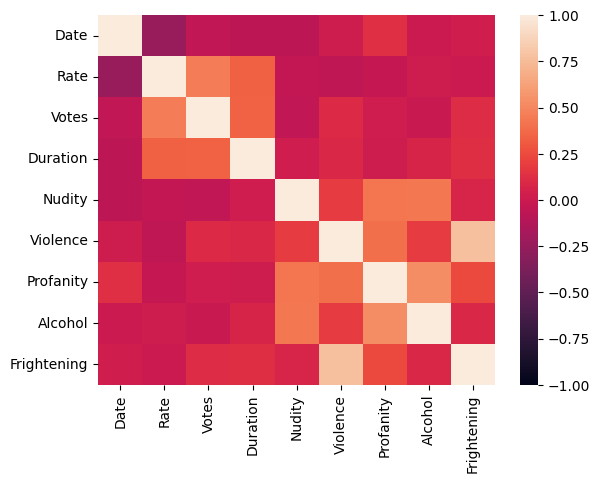

In [314]:
# Корреляционная матрица
corrMat = data.corr(numeric_only=True)
sns.heatmap(corrMat, vmin=-1.0, vmax=1.0)

print("Rate-Votes:", corrMat["Rate"]["Votes"])
print("Duration-Votes:", corrMat["Duration"]["Votes"])

Из матрицы понятно, что рейтинг зависит от количества оценок, а на факт оценки влияет продолжительность фильма.

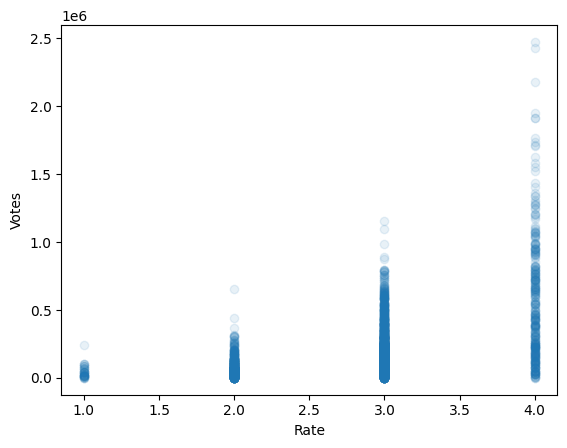

In [315]:
# Диаграмма рассеивания для признаков 'Rate', 'Votes':
plt.scatter(data['Rate'], data['Votes'], alpha=0.1)
plt.xlabel('Rate')
plt.ylabel('Votes')
pass

Можно заметить, что работы с низким рейтингом имеют малое количество оценок.

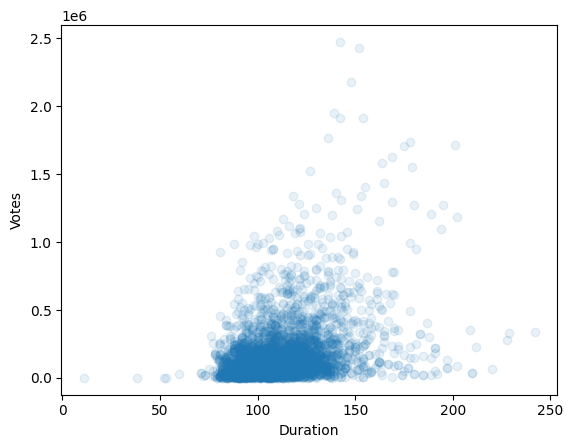

In [316]:
# Диаграмма рассеивания для признаков 'Duration', 'Votes':
plt.scatter(data['Duration'], data['Votes'], alpha=0.1)
plt.xlabel('Duration')
plt.ylabel('Votes')
pass

Здесь видно, что работы, длинной менее 70  и более 200 минут имеют малое количество оценок.

**3. Классы**
Будем классифицировать по рейтингу

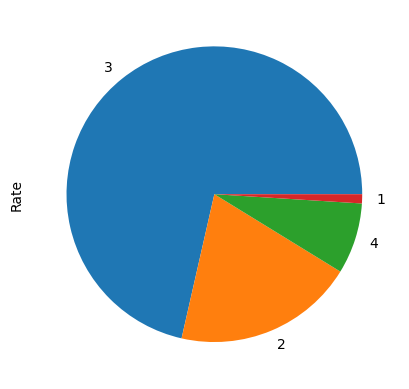

In [317]:
import collections
data['Rate'].value_counts().plot.pie();

**4. Нормализация**

Нормализация позволит повысить скорость сходимости алгоритма.

In [338]:
cls = data['Rate']
norm_columns  = ['Votes', 'Duration']
nonnorm_columns = ['Certificate', 'Nudity', 'Violence', 'Profanity', 'Alcohol', 'Frightening']
data_nonnorm = data[nonnorm_columns]

data_norm = data[norm_columns]
data_norm.describe()
data_norm = (data_norm - data_norm.mean(axis = 0))/data_norm.std(axis = 0)
data_norm.describe()

data = data[numerical_columns]
data = pd.concat((data_norm, data_nonnorm), axis = 1)
data.head(10)

,Votes,Duration,Certificate,Nudity,Violence,Profanity,Alcohol,Frightening
0,-0.239125,2.517629,12,1,2,1,1,2
1,-0.438656,-0.990798,18,0,0,3,0,2
2,-0.612268,0.451022,18,2,3,3,2,2
3,-0.596889,-0.654373,12,0,2,2,1,2
4,-0.344174,2.133144,12,0,2,0,1,2
6,-0.021483,0.210718,12,1,2,2,0,1
19,0.411115,1.123870,12,0,2,1,1,2
20,-0.708550,1.988962,18,3,3,2,1,3
22,-0.227985,1.027749,12,0,2,1,1,1
25,1.161481,1.796719,12,1,2,1,1,2


**5. Выборки**

In [339]:
from sklearn.model_selection import train_test_split

X_train, X_test, Y_train, Y_test = train_test_split(
    data, cls, test_size = 0.3, random_state = 45)

print("Train:", X_train.shape)
print("Test:", X_test.shape)

Train: (2858, 8)
Test: (1226, 8)


**6. Классификатор ближайших соседей**



In [343]:
%%time
from sklearn.model_selection import GridSearchCV
nnb = [5, 10, 15, 20]
knn = KNeighborsClassifier()
grid = GridSearchCV(knn, param_grid = {'n_neighbors': nnb}, cv=10)
grid.fit(X_train, Y_train)

best_cv_err = 1 - grid.best_score_
best_n_neighbors = grid.best_estimator_.n_neighbors
print("Оптимальное кол-во соседей - ", best_n_neighbors)

knn = KNeighborsClassifier(n_neighbors = best_n_neighbors).fit(X_train, Y_train)

err_train = np.mean(Y_train != knn.predict(X_train))
err_test  = np.mean(Y_test  != knn.predict(X_test))

print("Ошибка на тренировочном наборе - ", err_train)
print("Ошибка на тестовом наборе - ", err_test)

Оптимальное кол-во соседей -  20
Ошибка на тренировочном наборе -  0.24737578726382084
Ошибка на тестовом наборе -  0.2765089722675367
CPU times: user 1.93 s, sys: 14.3 ms, total: 1.95 s
Wall time: 2.1 s


**7. SVC**



In [344]:
%%time
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
Cs = 10.**np.arange(-5, 5)
gamma_array = 10.**np.arange(-5, 5)
svc = SVC(gamma='auto')
grid = GridSearchCV(svc, cv=3, param_grid = {'C': Cs, 'gamma': gamma_array})
grid.fit(X_train, Y_train)

best_cv_err = 1 - grid.best_score_
best_C = grid.best_estimator_.C
print(best_cv_err, best_C)

0.23583200331549203 1000.0
CPU times: user 2min 19s, sys: 181 ms, total: 2min 19s
Wall time: 2min 28s


**8. Выводы**

В процессе выполнения работы были прочитаны и подготовленны данные (удаление, преобразование, изменение). В итоге было исключено 2094 строки.

После изучения корреляционной матрицы были получены данные о зависимости столбцов. Рейтинг (Rate) зависит от количества оценок (Votes), а на факт оценки влияет продолжительность фильма (Duration). Также наблюдается закономерность - чем выше рейтинг фильма, тем больше он имеет оценок.

Перед применением алгоритмов, для удобства, данные были разбиты на 4 класса рейтинга.
Классификатор ближайших соседей показал ошибку на тестовом наборе 0.28 (Время - 2.1 сек).
SVC показал ошибку 0.24, но при этом затраты времени намного превышают прошлый алгоритм - 2 минуты 28 сек.


